### 数据来源：某企业销售的6种商品所对应的送货及用户反馈数据
### 解决问题：
##### 1、配送服务是否存在问题
##### 2、是否存在尚有潜力的销售区域
##### 3、商品是否存在质量问题

### 先放结论：
##### 1、货品4→西北，货品2→马来西亚两条线路存在较大问题，急需提升时效
##### 2、货品2在华东地区还有较大市场空间，适合加大投入，同时货品2在西北配送时效长，用户拒收率高，从成本角度考虑，应该减少投入
##### 3、货品1、2、4质量存在问题，建议扩大抽检范围，增大质检力度

### 分析过程如下
#### 一、数据清洗
##### ① 重复值、缺失值、格式调整
##### ② 异常值处理（比如：销售金额存在等于0的，数量和销售金额的标准差都在均值的8倍以上等）
#### 二、数据规整
##### 比如：增加一项辅助列：月份
#### 三、数据分析并可视化

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
plt.rcParams['font.sans-serif'] = 'SimHei' ## 设置中文显示

# 数据清洗

In [4]:
data = pd.read_csv(r'D:\data analysis\data_wuliu.csv',encoding='gbk')
data.head()

,订单号,订单行,销售时间,交货时间,货品交货状况,货品,货品用户反馈,销售区域,数量,销售金额
0,P096311,10,2016-7-30,2016-9-30,晚交货,货品3,质量合格,华北,2.0,"1052,75元"
1,P096826,10,2016-8-30,2016-10-30,按时交货,货品3,质量合格,华北,10.0,"11,50万元"
2,NaN,20,2016-8-30,2016-10-30,按时交货,货品3,质量合格,华北,10.0,"11,50万元"
3,P097435,10,2016-7-30,2016-9-30,按时交货,货品1,返修,华南,2.0,"6858,77元"
4,P097446,60,2016-11-26,2017-1-26,晚交货,货品3,质量合格,华北,15.0,"129,58元"


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1161 entries, 0 to 1160
Data columns (total 10 columns):
订单号       1159 non-null object
订单行       1161 non-null int64
销售时间      1161 non-null object
交货时间      1161 non-null object
货品交货状况    1159 non-null object
货品        1161 non-null object
货品用户反馈    1161 non-null object
销售区域      1161 non-null object
数量        1157 non-null float64
销售金额      1161 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 90.8+ KB


In [ ]:
# 通过info()可以看出，包括10列数据，名字，数据量，格式等，可以得出：
# 1.订单号，货品交货情况，数量：存在缺失值，但是缺失量不大，可以删除
# 2.订单行，对分析无关紧要，可以考虑删除
# 3.销售金额格式不对（万元|元，逗号问题）,数据类型需要转换成int|float

## 重复值、缺失值、格式调整

In [8]:
#删除重复记录
data.drop_duplicates(keep='first',inplace=True) #重复值保留第一个，在原数据中修改
#删除缺失值（na,删除带有na的整行数据,axis=0（按行删除）,how='any'（只要有一个NA，就整行删除，默认值）
data.dropna(axis=0,how='any',inplace=True)
#删除订单行(重复运行会报错，因为第一次已经删除了订单行这一列，需要重新加载数据)，axis=1（按列删除）
data.drop(columns=['订单行'],inplace=True,axis=1)
print(data.info())
#更新索引(drop=True:把原来的索引index列删除，重置index)
data.reset_index(drop=True,inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1146 entries, 0 to 1160
Data columns (total 9 columns):
订单号       1146 non-null object
销售时间      1146 non-null object
交货时间      1146 non-null object
货品交货状况    1146 non-null object
货品        1146 non-null object
货品用户反馈    1146 non-null object
销售区域      1146 non-null object
数量        1146 non-null float64
销售金额      1146 non-null object
dtypes: float64(1), object(8)
memory usage: 89.5+ KB
None


In [12]:
data.head()

,订单号,销售时间,交货时间,货品交货状况,货品,货品用户反馈,销售区域,数量,销售金额
0,P096311,2016-7-30,2016-9-30,晚交货,货品3,质量合格,华北,2.0,105275.0
1,P096826,2016-8-30,2016-10-30,按时交货,货品3,质量合格,华北,10.0,11500000.0
2,P097435,2016-7-30,2016-9-30,按时交货,货品1,返修,华南,2.0,685877.0
3,P097446,2016-11-26,2017-1-26,晚交货,货品3,质量合格,华北,15.0,12958.0
4,P097446,2016-11-26,2017-1-26,晚交货,货品3,拒货,华北,15.0,3239.0


In [ ]:
#取出销售金额列，对每一个数据进行清洗
#编写自定义过滤函数：删除逗号，转成float，如果是万元则*10000，否则，删除元

In [9]:
def data_deal(number):
    if number.find('万元')!= -1:#这个字符串的内容，如果找到，就会返回改字符串所在的下标，如果没有找到，就会返回-1
        number_new = float(number[:number.find('万元')].replace(',',''))*10000
        # 先找出带有逗号的数字，切片切出来后，取出数字，找到万元，把逗号替换成空，转成浮点
        # 找到带有万元的，取出数字，去掉逗号，转成float，*10000
        pass
    else: #找到带有元的，把元替换成空值，把逗号替换成空值，转成float
        number_new = float(number.replace('元','').replace(',',''))
        pass
    return number_new
data['销售金额'] = data['销售金额'].map(data_deal)# 把data['销售金额'].map(data_deal)处理完的再存储到这列中
data

,订单号,销售时间,交货时间,货品交货状况,货品,货品用户反馈,销售区域,数量,销售金额
0,P096311,2016-7-30,2016-9-30,晚交货,货品3,质量合格,华北,2.0,105275.0
1,P096826,2016-8-30,2016-10-30,按时交货,货品3,质量合格,华北,10.0,11500000.0
2,P097435,2016-7-30,2016-9-30,按时交货,货品1,返修,华南,2.0,685877.0
3,P097446,2016-11-26,2017-1-26,晚交货,货品3,质量合格,华北,15.0,12958.0
4,P097446,2016-11-26,2017-1-26,晚交货,货品3,拒货,华北,15.0,3239.0
...,...,...,...,...,...,...,...,...,...
1141,P299901,2016-12-15,2017-3-15,按时交货,货品6,质量合格,马来西亚,2.0,20041.0
1142,P302956,2016-12-22,2017-3-22,按时交货,货品2,拒货,华东,20.0,7944.0
1143,P303801,2016-12-15,2017-3-15,按时交货,货品2,质量合格,华东,1.0,19408.0
1144,P307276,2016-12-22,2017-3-22,按时交货,货品6,质量合格,马来西亚,1.0,3218.0


## 异常值处理

In [10]:
data.describe()

,数量,销售金额
count,1146.000000,1.146000e+03
mean,76.069372,1.223488e+05
std,589.416486,1.114599e+06
min,1.000000,0.000000e+00
25%,1.000000,2.941500e+03
50%,1.000000,9.476500e+03
75%,4.000000,3.576775e+04
max,11500.000000,3.270000e+07


In [11]:
# 销售金额==0,采用删除方法，因为数据量很小
data=data[data['销售金额']!=0]
data.describe()

,数量,销售金额
count,1145.000000,1.145000e+03
mean,76.134934,1.224557e+05
std,589.669861,1.115081e+06
min,1.000000,5.100000e+01
25%,1.000000,2.946000e+03
50%,1.000000,9.486000e+03
75%,4.000000,3.577300e+04
max,11500.000000,3.270000e+07


In [ ]:
# 销售金额和数量存在严重右偏现象，在电商领域2/8很正常，无需处理

In [13]:
data

,订单号,销售时间,交货时间,货品交货状况,货品,货品用户反馈,销售区域,数量,销售金额
0,P096311,2016-7-30,2016-9-30,晚交货,货品3,质量合格,华北,2.0,105275.0
1,P096826,2016-8-30,2016-10-30,按时交货,货品3,质量合格,华北,10.0,11500000.0
2,P097435,2016-7-30,2016-9-30,按时交货,货品1,返修,华南,2.0,685877.0
3,P097446,2016-11-26,2017-1-26,晚交货,货品3,质量合格,华北,15.0,12958.0
4,P097446,2016-11-26,2017-1-26,晚交货,货品3,拒货,华北,15.0,3239.0
...,...,...,...,...,...,...,...,...,...
1141,P299901,2016-12-15,2017-3-15,按时交货,货品6,质量合格,马来西亚,2.0,20041.0
1142,P302956,2016-12-22,2017-3-22,按时交货,货品2,拒货,华东,20.0,7944.0
1143,P303801,2016-12-15,2017-3-15,按时交货,货品2,质量合格,华东,1.0,19408.0
1144,P307276,2016-12-22,2017-3-22,按时交货,货品6,质量合格,马来西亚,1.0,3218.0


# 数据规整

In [14]:
data['销售时间'] = pd.to_datetime(data['销售时间'])#先取出'销售时间'这列，对这列数据进行数据转换，再放回到原数据列里面
data['月份'] = data['销售时间'].apply(lambda x:x.month)#取出'销售时间'这列,对这列里的每一条记录分别取出月份，放到新的一列中
data

<ipython-input-14-f329c9f31c36>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['销售时间'] = pd.to_datetime(data['销售时间'])#先取出'销售时间'这列，对这列数据进行数据转换，再放回到原数据列里面
<ipython-input-14-f329c9f31c36>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['月份'] = data['销售时间'].apply(lambda x:x.month)#取出'销售时间'这列,对这列里的每一条记录分别取出月份，放到新的一列中


,订单号,销售时间,交货时间,货品交货状况,货品,货品用户反馈,销售区域,数量,销售金额,月份
0,P096311,2016-07-30,2016-9-30,晚交货,货品3,质量合格,华北,2.0,105275.0,7
1,P096826,2016-08-30,2016-10-30,按时交货,货品3,质量合格,华北,10.0,11500000.0,8
2,P097435,2016-07-30,2016-9-30,按时交货,货品1,返修,华南,2.0,685877.0,7
3,P097446,2016-11-26,2017-1-26,晚交货,货品3,质量合格,华北,15.0,12958.0,11
4,P097446,2016-11-26,2017-1-26,晚交货,货品3,拒货,华北,15.0,3239.0,11
...,...,...,...,...,...,...,...,...,...,...
1141,P299901,2016-12-15,2017-3-15,按时交货,货品6,质量合格,马来西亚,2.0,20041.0,12
1142,P302956,2016-12-22,2017-3-22,按时交货,货品2,拒货,华东,20.0,7944.0,12
1143,P303801,2016-12-15,2017-3-15,按时交货,货品2,质量合格,华东,1.0,19408.0,12
1144,P307276,2016-12-22,2017-3-22,按时交货,货品6,质量合格,马来西亚,1.0,3218.0,12


# 数据分析并可视化
## 配送服务是否存在问题
### 月份维度

In [16]:
data['货品交货状况'] = data['货品交货状况'].str.strip()#取出这一列，转成str,再去除首尾空格，处理完的数据再给它还原回去（再存储到这一列）
data1 = data.groupby(['月份','货品交货状况']).size().unstack()# 对分组的数据进行数量统计，用size(压缩显示状态）,再用unstack转成df行列的形式
data1

<ipython-input-16-aeffcf2ca503>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['货品交货状况'] = data['货品交货状况'].str.strip()#取出这一列，转成str,再去除首尾空格，处理完的数据再给它还原回去（再存储到这一列）


货品交货状况,按时交货,晚交货
月份,,
7,189,13
8,218,35
9,122,9
10,238,31
11,101,25
12,146,18


In [17]:
data1['按时交货率'] = data1['按时交货']/(data1['按时交货']+data1['晚交货'])
data1
#从按时交货率来看，第四季度低于第三季度，猜测可能是气候原因造成

货品交货状况,按时交货,晚交货,按时交货率
月份,,,
7,189,13,0.935644
8,218,35,0.861660
9,122,9,0.931298
10,238,31,0.884758
11,101,25,0.801587
12,146,18,0.890244


### 销售区域维度

In [21]:
data1 = data.groupby(['销售区域','货品交货状况']).size().unstack()
data1['按时交货率'] = data1['按时交货']/(data1['按时交货']+data1['晚交货'])
data1.sort_values(by='按时交货率',ascending=False) #按按时交货率降序排序
# #西北地区存在突出的延时交货问题，急需解決

货品交货状况,按时交货,晚交货,按时交货率
销售区域,,,
泰国,183,4,0.978610
马来西亚,310,16,0.950920
华南,10,1,0.909091
华北,226,27,0.893281
华东,268,39,0.872964
西北,17,44,0.278689


### 货品维度

In [22]:
data1 = data.groupby(['货品','货品交货状况']).size().unstack()
data1['按时交货率'] = data1['按时交货']/(data1['按时交货']+data1['晚交货'])
data1.sort_values(by='按时交货率',ascending=False)
#货品4晚交货情况非常严重，其余货品相对较好

货品交货状况,按时交货,晚交货,按时交货率
货品,,,
货品5,183,4,0.978610
货品6,309,7,0.977848
货品1,27,2,0.931034
货品3,212,26,0.890756
货品2,269,48,0.848580
货品4,14,44,0.241379


### 货品和销售区域结合

In [24]:
data1 = data.groupby(['货品','销售区域','货品交货状况']).size().unstack()
data1['按时交货率'] = data1['按时交货']/(data1['按时交货']+data1['晚交货'])
data1.sort_values(by='按时交货率',ascending=False)
#销售区域：最差在西北地区，货品有1和4，主要是货品4送过较晚导致
#货品：最差的货品2，主要送往华东和马来西亚，主要是马来西亚的送货较晚导致。

货品交货状况     按时交货   晚交货     按时交货率
货品  销售区域                       
货品5 泰国    183.0   4.0  0.978610
货品6 马来西亚  309.0   7.0  0.977848
货品1 华北     14.0   1.0  0.933333
    华南     10.0   1.0  0.909091
货品3 华北    212.0  26.0  0.890756
货品2 华东    268.0  39.0  0.872964
货品4 西北     14.0  44.0  0.241379
货品2 马来西亚    1.0   9.0  0.100000
货品1 西北      3.0   NaN       NaN

## 是否存在尚有潜力的销售区域

### 月份维度

In [26]:
data1 = data.groupby(['月份','货品'])['数量'].sum().unstack()#如1月份的时候运输货品1有多少数量...，再用unstack转成df的行列形式
data1

货品,货品1,货品2,货品3,货品4,货品5,货品6
月份,,,,,,
7,283.0,491.0,2041.5,414.0,733.0,1649.0
8,1413.0,3143.0,1045.0,1188.0,2381.0,1181.0
9,1693.0,3020.0,2031.0,NaN,271.0,343.0
10,4.0,28420.0,1684.0,2542.0,1984.0,2358.0
11,20.0,2042.0,100.0,3.0,14.0,383.0
12,4.0,18205.0,2172.0,1082.0,350.0,2487.0


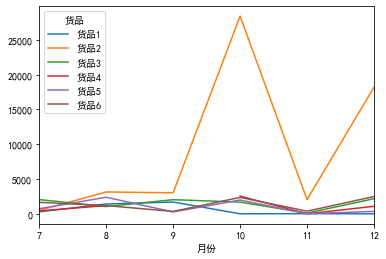

In [27]:
data1.plot(kind='line')
# 货品2在10月和12月份，销量猛增，原因猜测有二：1.公司加大营销力度  2.开发了新的市场(后续有结论)

### 不同区域

In [28]:
data1 = data.groupby(['销售区域','货品'])['数量'].sum().unstack() #求每组的‘数量’求和，再转成DF行列形式
data1
# 从销售区域看，每种货品销售区域为1~3个，货品1有三个销售区域，货品2有两个销售区域，其余货品均有1个销售区域

货品,货品1,货品2,货品3,货品4,货品5,货品6
销售区域,,,,,,
华东,NaN,53811.0,NaN,NaN,NaN,NaN
华北,2827.0,NaN,9073.5,NaN,NaN,NaN
华南,579.0,NaN,NaN,NaN,NaN,NaN
泰国,NaN,NaN,NaN,NaN,5733.0,NaN
西北,11.0,NaN,NaN,5229.0,NaN,NaN
马来西亚,NaN,1510.0,NaN,NaN,NaN,8401.0


### 月份和区域

In [30]:
data1 = data.groupby(['月份','销售区域','货品'])['数量'].sum().unstack()
data1

货品          货品1      货品2     货品3     货品4     货品5     货品6
月份 销售区域                                                 
7  华东       NaN    489.0     NaN     NaN     NaN     NaN
   华北       1.0      NaN  2041.5     NaN     NaN     NaN
   华南     282.0      NaN     NaN     NaN     NaN     NaN
   泰国       NaN      NaN     NaN     NaN   733.0     NaN
   西北       NaN      NaN     NaN   414.0     NaN     NaN
   马来西亚     NaN      2.0     NaN     NaN     NaN  1649.0
8  华东       NaN   1640.0     NaN     NaN     NaN     NaN
   华北    1410.0      NaN  1045.0     NaN     NaN     NaN
   华南       3.0      NaN     NaN     NaN     NaN     NaN
   泰国       NaN      NaN     NaN     NaN  2381.0     NaN
   西北       NaN      NaN     NaN  1188.0     NaN     NaN
   马来西亚     NaN   1503.0     NaN     NaN     NaN  1181.0
9  华东       NaN   3019.0     NaN     NaN     NaN     NaN
   华北    1409.0      NaN  2031.0     NaN     NaN     NaN
   华南     283.0      NaN     NaN     NaN     NaN     NaN
   泰国       NaN      NaN     NaN     NaN   271.0     NaN
   西北       1.0      NaN     NaN     NaN     NaN     NaN
   马来西亚     NaN      1.0     NaN     NaN     NaN   343.0
10 华东       NaN  28420.0     NaN     NaN     NaN     NaN
   华北       3.0      NaN  1684.0     NaN     NaN     NaN
   泰国       NaN      NaN     NaN     NaN  1984.0     NaN
   西北       1.0      NaN     NaN  2542.0     NaN     NaN
   马来西亚     NaN      NaN     NaN     NaN     NaN  2358.0
11 华东       NaN   2041.0     NaN     NaN     NaN     NaN
   华北       2.0      NaN   100.0     NaN     NaN     NaN
   华南       9.0      NaN     NaN     NaN     NaN     NaN
   泰国       NaN      NaN     NaN     NaN    14.0     NaN
   西北       9.0      NaN     NaN     3.0     NaN     NaN
   马来西亚     NaN      1.0     NaN     NaN     NaN   383.0
12 华东       NaN  18202.0     NaN     NaN     NaN     NaN
   华北       2.0      NaN  2172.0     NaN     NaN     NaN
   华南       2.0      NaN     NaN     NaN     NaN     NaN
   泰国       NaN      NaN     NaN     NaN   350.0     NaN
   西北       NaN      NaN     NaN  1082.0     NaN     NaN
   马来西亚     NaN      3.0     NaN     NaN     NaN  2487.0

In [31]:
data1['货品2']
#货品2在10，12月份销量猛增，原因主要发生在原有销售区域（华东）
#同样，分析出在7，8，9，11月份销售数量还有很大提升空间，可以适当加大营销力度

月份  销售区域
7   华东        489.0
    华北          NaN
    华南          NaN
    泰国          NaN
    西北          NaN
    马来西亚        2.0
8   华东       1640.0
    华北          NaN
    华南          NaN
    泰国          NaN
    西北          NaN
    马来西亚     1503.0
9   华东       3019.0
    华北          NaN
    华南          NaN
    泰国          NaN
    西北          NaN
    马来西亚        1.0
10  华东      28420.0
    华北          NaN
    泰国          NaN
    西北          NaN
    马来西亚        NaN
11  华东       2041.0
    华北          NaN
    华南          NaN
    泰国          NaN
    西北          NaN
    马来西亚        1.0
12  华东      18202.0
    华北          NaN
    华南          NaN
    泰国          NaN
    西北          NaN
    马来西亚        3.0
Name: 货品2, dtype: float64

## 商品是否存在质量问题

In [33]:
data['货品用户反馈'] = data['货品用户反馈'].str.strip()  #对字符串进行首位空格的去除，再存储到这列中
data1 = data.groupby(['货品','销售区域'])['货品用户反馈'].value_counts().unstack()
# 先对'货品'这列分组，再对'销售区域'这列分组，然后取出'货品用户反馈'这列，因为这列是字符串，所以不能用sum求和，要用值的数量统计-value_counts(),最后转成df行列格式
data1

<ipython-input-33-3a55d9ed49b8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['货品用户反馈'] = data['货品用户反馈'].str.strip()  #对字符串进行首位空格的去除，再存储到这列中


货品用户反馈      拒货   质量合格    返修
货品  销售区域                   
货品1 华北     NaN    3.0  12.0
    华南     5.0    4.0   2.0
    西北     NaN    1.0   2.0
货品2 华东    72.0  184.0  51.0
    马来西亚   6.0    1.0   3.0
货品3 华北    31.0  188.0  19.0
货品4 西北     NaN    9.0  49.0
货品5 泰国    14.0  144.0  29.0
货品6 马来西亚  56.0  246.0  14.0

In [34]:
data1['拒货率'] = data1['拒货'] /data1.sum(axis=1)  #按行进行求和汇总（拒货+质量合格+返修）
data1['返修率'] = data1['返修'] /data1.sum(axis=1)
data1['合格率'] = data1['质量合格'] /data1.sum(axis=1)
data1.sort_values(['合格率','返修率','拒货率'],ascending=False)#先对'合格率'降序排序，如果'合格率'相等，再按'返修率'排序,如果'返修率"相等，再按’拒货率'排序

货品用户反馈      拒货   质量合格    返修       拒货率       返修率       合格率
货品  销售区域                                                 
货品3 华北    31.0  188.0  19.0  0.130252  0.079788  0.789219
货品6 马来西亚  56.0  246.0  14.0  0.177215  0.044279  0.777936
货品5 泰国    14.0  144.0  29.0  0.074866  0.155018  0.769108
货品2 华东    72.0  184.0  51.0  0.234528  0.165997  0.598568
货品1 华南     5.0    4.0   2.0  0.454545  0.174603  0.343963
    西北     NaN    1.0   2.0       NaN  0.666667  0.272727
    华北     NaN    3.0  12.0       NaN  0.800000  0.189873
货品4 西北     NaN    9.0  49.0       NaN  0.844828  0.152945
货品2 马来西亚   6.0    1.0   3.0  0.600000  0.283019  0.091886

In [ ]:
# 货品3.6.5合格率均较高，返修率比较低，说明质量还可以
# 货品1.2.4合格率较低，返修率较高，质量存在一定的问题，需要改善
# 货品2在马拉西亚的拒货率最高，同时，在货品2在马拉西亚的按时交货率也非常低。猜测：马来西亚人对送货的时效性要求较高，
# 如果达不到，则往往考虑拒货。
# 考虑到货品2主要在华东地区销售量大，可以考虑增大在华东的投资，适当加大马来西亚的投入。